In [40]:
import numpy as np
import pandas as pd
import datetime as dt
import time
import os
import tensorflow as tf
import pickle
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from playsound import playsound
from ta import add_all_ta_features
from ta.momentum import *
from ta.volume import *
from ta.trend import *
from ta.volatility import *

In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [12]:
X = np.load('C:/Users/alexm/Desktop/pythonstuff/capstone/storage/1yeardata/X.npy')
data = pd.read_pickle('C:/Users/alexm/Desktop/pythonstuff/capstone/storage/1yeardata/data.pickle')
meta = pd.read_pickle('C:/Users/alexm/Desktop/pythonstuff/capstone/storage/1yeardata/meta.pickle')

In [13]:
print(data.shape)
print(meta.shape)
print(X.shape)

(1616, 6986)
(499, 3)
(499, 1616, 14)


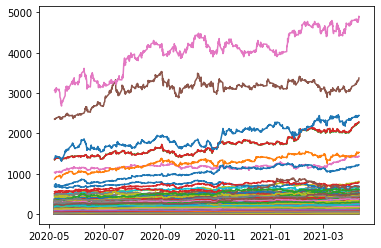

In [14]:
for j in meta['Ticker']:
  plt.plot(data[j]['Close'])

In [15]:
#pd.set_option('display.max_columns', None)

(18388.8125, 18726.8125)

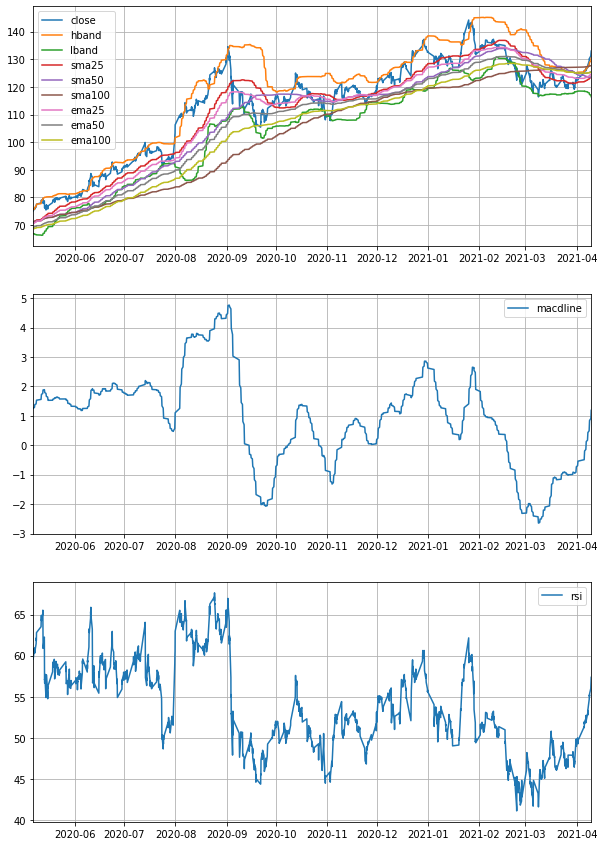

In [16]:
#example visualization of aapl TIs
aapl = data['AAPL']
fig = plt.figure(figsize=(10,15))
ax1 = fig.add_subplot(311)
plt.plot(aapl['Close'])
plt.plot(aapl['H_BAND'])
plt.plot(aapl['L_BAND'])
plt.plot(aapl['SMA25'])
plt.plot(aapl['SMA50'])
plt.plot(aapl['SMA100'])
plt.plot(aapl['EMA25'])
plt.plot(aapl['EMA50'])
plt.plot(aapl['EMA100'])
plt.legend(['close','hband','lband','sma25','sma50','sma100','ema25','ema50','ema100'])
plt.grid('on')
plt.xlim(aapl['Close'].index[0],aapl['Close'].index[-1])
ax2 = fig.add_subplot(312)
plt.plot(aapl['MACD'])
plt.grid('on')
plt.xlim(aapl['Close'].index[0],aapl['Close'].index[-1])
plt.legend(['macdline'])
ax3 = fig.add_subplot(313)
plt.plot(aapl['RSI'])
plt.legend(['rsi'])
plt.grid('on')
plt.xlim(aapl['Close'].index[0],aapl['Close'].index[-1])

In [17]:
#X numpy structure:
#X[Ticker # corresponded with meta index (499 of these)][datetime index # (X of these)][OHLC/Tis]

#data preprocessing
X = X.astype('float32')

#let's focus on AAPL
index_AAPL = meta.loc[meta['Ticker'] == 'AAPL'].index[0]
X_AAPL = X[index_AAPL]

scaler = StandardScaler()
scaler = scaler.fit(X_AAPL)
X_AAPL_scaled = scaler.transform(X_AAPL)
#for when we have to invert predictions
#X_AAPL_inverted = scaler.inverse_transform(X_AAPL_scaled)

In [18]:
X_AAPL_scaled.shape

(1616, 14)

In [19]:
window_len = 5 #daily rows; val of 5 looks back on 5 days worth of trading data
n_features = 14 #for later on

In [20]:
#x_realpredicted is just for forecast evaluation purposes/those 5 days ahead that we are comparing our forecasts on, kind of like test data but not really
x_realpredicted = X_AAPL_scaled[2512:2517]
x_realpredicted = np.concatenate((x_realpredicted,np.zeros((2512,n_features))))
x_realpredicted = scaler.inverse_transform(x_realpredicted)
x_realpredicted = x_realpredicted[:5,3]
print(x_realpredicted.shape)
X_AAPL_scaled_train = X_AAPL_scaled[:2512]

(5,)


In [21]:
#now let's prepare our rolling windows
x_train = []
for i in range(X_AAPL_scaled_train.shape[0]-window_len+1):
  x_train.append(X_AAPL_scaled_train[i:i+window_len,:])

x_train=np.array(x_train)

In [22]:
x_train.shape

(1612, 5, 14)

In [23]:
def inverse_and_supply(data,scaler):
    inverted = np.concatenate((data,np.zeros((X_AAPL_scaled.shape[0]-window_len+1,n_features))))
    inverted = scaler.inverse_transform(inverted)
    return inverted[5,0]

---
### Network Functions
---

In [24]:
def discriminator(in_shape,lr):
  inputs = Input(shape=(in_shape))
  d1 = Dense(64)(inputs)
  LR1 = LeakyReLU()(d1)
  d2 = Dense(16)(LR1)
  LR2 = LeakyReLU()(d2)
  outputs = Dense(1,activation='sigmoid')(LR2)
  model_D = keras.Model(inputs=inputs, outputs=outputs, name='discriminator')

  opt=Adam(lr=lr)
  model_D.compile(loss='binary_crossentropy',optimizer=opt)
  return model_D

In [25]:
def generator(in_shape,out_dim,neurons_lstm):
  inputs = Input(in_shape,name='window_input')
  LSTM1 = LSTM(neurons_lstm,input_shape=in_shape,return_sequences=False)(inputs)
  DO1 = Dropout(0.5)(LSTM1)
  #LSTM2 = LSTM(neurons_lstm,input_shape=in_shape,return_sequences=False)(DO1)
  #DO2 = Dropout(0.5)(LSTM2)
  D1 = Dense(out_dim)(DO1)
  LR = LeakyReLU()(D1)
  outputs = Reshape((1,out_dim))(LR)
  model_G = keras.Model(inputs=inputs,outputs=outputs,name='generator')

  return model_G

In [26]:
def gan_model(model_D, model_G,gen_input_shape, lr, lossweights):
  model_D.trainable = False
  ins = Input((gen_input_shape))
  predicted = model_G(ins)
  #concat with ins
  predicted_concat = concatenate([ins,predicted],axis=1)
  #print(predicted_concat.shape)
  outs = model_D(predicted_concat)
  model_GAN = keras.Model(inputs=ins,outputs=outs,name='GAN')

  opt = Adam(lr=lr)
  model_GAN.compile(loss=['binary_crossentropy','mean_squared_error'],loss_weights=lossweights ,optimizer=opt)
  return model_GAN

---
### Training Functions
---

In [27]:
#not used in LSTM-GAN
def noise_vector(latent_dim, batch_size):
  noise = np.random.randn(latent_dim * batch_size)
  noise = np.reshape(noise, (batch_size,1, latent_dim))
  return noise

In [28]:
def generated_sample(window_data, model):
  #latent_space = noise_vector(latent_dim, batch_size)
  window_data = window_data[np.newaxis,:,:]
  x_predicted = model.predict(window_data)
  x_fake = np.concatenate((window_data,x_predicted),axis=1)
  y_fake = np.zeros((1,1))
  return x_fake, y_fake

In [29]:
def real_sample(window_data, lookahead_data):
  lookahead_data = lookahead_data[-1,:]
  lookahead_data = lookahead_data[np.newaxis,:]
  x_real = np.concatenate((window_data,lookahead_data),axis=0)
  x_real = x_real[np.newaxis,:,:]
  y_real = np.ones((1,1))
  return x_real, y_real

In [30]:
def train(model_D,model_G,model_GAN, dataset, epochs=1):
  global generator_loss, discriminator_loss
 
  for j in range(epochs):
    for i in range(dataset.shape[0]-1): 
      #start with discriminator training:
      X_real, y_real = real_sample(dataset[i],dataset[i+1])
      X_fake, y_fake = generated_sample(dataset[i],model_G) 
      X, y = np.vstack((X_real,X_fake)), np.vstack((y_real,y_fake))
      
      disc_loss = model_D.train_on_batch(X,y)
      
      #adversarial training
      X_GAN = dataset[i]
      X_GAN = X_GAN[np.newaxis,:,:]
      y_GAN = np.ones((1,1))
      
      GAN_loss = model_GAN.train_on_batch(X_GAN,y_GAN)
      
      generator_loss = np.append(generator_loss,GAN_loss)
      discriminator_loss = np.append(discriminator_loss,disc_loss)
      if (i % 50) == 0:
        print('>%d:%d, disc_loss=%.4f, GAN_loss=%.4f' % (j+1,i,disc_loss,GAN_loss))
      
    #print('>%d,  disc_loss=%.4f , GAN_loss=%.4f' % (j+1,disc_loss,GAN_loss))

---
### Training
---

In [49]:
disc_input_shape = (6,n_features)
gen_input_shape = (window_len,n_features)
#latent_dim = 100
loss_weights = [0.5,0.5]
gan_learning_rate = 1e-3
disc_learning_rate = 1e-3
lstm_neurons = 16
model_discriminator = discriminator(disc_input_shape,disc_learning_rate)
#model_discriminator.summary()
model_generator = generator(gen_input_shape,n_features,lstm_neurons)
#model_generator.summary()
model_GAN = gan_model(model_discriminator,model_generator,gen_input_shape,gan_learning_rate,loss_weights)
now = dt.datetime.now()
now = now.strftime('%Y-%m-%d_%H-%M-%S')
plot_model(model_GAN,show_shapes=True,show_layer_names=True,to_file='storage/architectures/ganarchs/gan_arch_%s.png' % (now))
plot_model(model_discriminator,show_shapes=True,show_layer_names=True,to_file='storage/architectures/discarchs/disc_arch_%s.png' % (now))
plot_model(model_generator,show_shapes=True,show_layer_names=True,to_file='storage/architectures/genarchs/gen_arch_%s.png' % (now))
img_disc = mpimg.imread('storage/architectures/discarchs/disc_arch_%s.png' % (now))
img_gen = mpimg.imread('storage/architectures/genarchs/gen_arch_%s.png' % (now))
img_gan = mpimg.imread('storage/architectures/ganarchs/gan_arch_%s.png' % (now))
#plot_model(model_GAN,show_shapes=True,show_layer_names=True)
generator_loss = np.array([])
discriminator_loss = np.array([])
epochs=10
start = time.time()
train(model_discriminator, model_generator, model_GAN, x_train, epochs=epochs)
end = str(dt.timedelta(seconds=(round(time.time() - start))))
#playsound('narration.mp3')

>1:0, disc_loss=0.6905, GAN_loss=0.2805
>1:50, disc_loss=0.6722, GAN_loss=0.3319
>1:100, disc_loss=0.6599, GAN_loss=0.3431
>1:150, disc_loss=0.6445, GAN_loss=0.4200
>1:200, disc_loss=0.6387, GAN_loss=0.4517
>1:250, disc_loss=0.6394, GAN_loss=0.4479
>1:300, disc_loss=0.6348, GAN_loss=0.6060
>1:350, disc_loss=0.6414, GAN_loss=0.4627
>1:400, disc_loss=0.6507, GAN_loss=0.3241
>1:450, disc_loss=0.6650, GAN_loss=0.2789
>1:500, disc_loss=0.6311, GAN_loss=0.3990
>1:550, disc_loss=0.6460, GAN_loss=0.6766
>1:600, disc_loss=0.6665, GAN_loss=0.3894
>1:650, disc_loss=0.6872, GAN_loss=0.4243
>1:700, disc_loss=0.6764, GAN_loss=0.2846
>1:750, disc_loss=0.6529, GAN_loss=0.3873
>1:800, disc_loss=0.6700, GAN_loss=0.3518
>1:850, disc_loss=0.6807, GAN_loss=0.3675
>1:900, disc_loss=0.6946, GAN_loss=0.3736
>1:950, disc_loss=0.6717, GAN_loss=0.3045
>1:1000, disc_loss=0.6662, GAN_loss=0.4131
>1:1050, disc_loss=0.7066, GAN_loss=0.3602
>1:1100, disc_loss=0.7056, GAN_loss=0.3657
>1:1150, disc_loss=0.6833, GAN_los

---
### Visualizations
---

Text(0.5, 0, 'Batches')

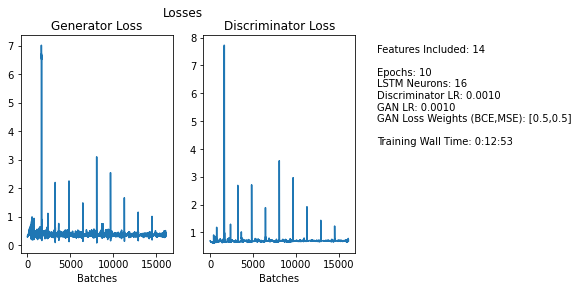

In [50]:
fig, axs = plt.subplots(1,2)
text = 'Features Included: %d\n\nEpochs: %d\nLSTM Neurons: %d\nDiscriminator LR: %.4f\nGAN LR: %.4f\nGAN Loss Weights (BCE,MSE): [%.1f,%.1f]\n\nTraining Wall Time: %s' % (n_features,epochs,lstm_neurons,disc_learning_rate,gan_learning_rate,loss_weights[0],loss_weights[1],end)
fig.suptitle('Losses')
fig.text(.95,.5,s=text)
axs[0].plot(generator_loss)
axs[0].set_title('Generator Loss')
axs[0].set_xlabel('Batches')
axs[1].plot(discriminator_loss)
axs[1].set_title('Discriminator Loss')
axs[1].set_xlabel('Batches')

In [51]:
#really slow prediction implementation, will redo later
real_close = []
predictions_close = []
for k in range(x_train.shape[0] - 1):
  if k % 100 == 0:
    print('>batch:',k)
  forecast_data = x_train[k]
  fakedistro,_ = generated_sample(forecast_data,model_generator)
  fakedistro = fakedistro[0]
  fakedistro_inverted = np.concatenate((fakedistro,np.zeros((X_AAPL_scaled.shape[0]-window_len+1,n_features))))
  fakedistro_inverted = scaler.inverse_transform(fakedistro_inverted)
  fakedistro_inverted = fakedistro_inverted[0:6,:]
  
  predictions_close = np.append(predictions_close,fakedistro_inverted[5,0])

  #prepare forecast data with t+1
  real_data = forecast_data
  one_ahead = x_train[k+1][-1]
  one_ahead = one_ahead[np.newaxis,:]
  real_data = np.concatenate((real_data,one_ahead),axis=0)
  real_data_inverted = np.concatenate((real_data,np.zeros((X_AAPL_scaled.shape[0]-window_len+1,n_features))))
  real_data_inverted = scaler.inverse_transform(real_data_inverted)
  real_data_inverted = real_data_inverted[0:6,:]

  real_close = np.append(real_close,real_data_inverted[5,0])

#playsound('predictions.mp3')

>batch: 0
>batch: 100
>batch: 200
>batch: 300
>batch: 400
>batch: 500
>batch: 600
>batch: 700
>batch: 800
>batch: 900
>batch: 1000
>batch: 1100
>batch: 1200
>batch: 1300
>batch: 1400
>batch: 1500
>batch: 1600


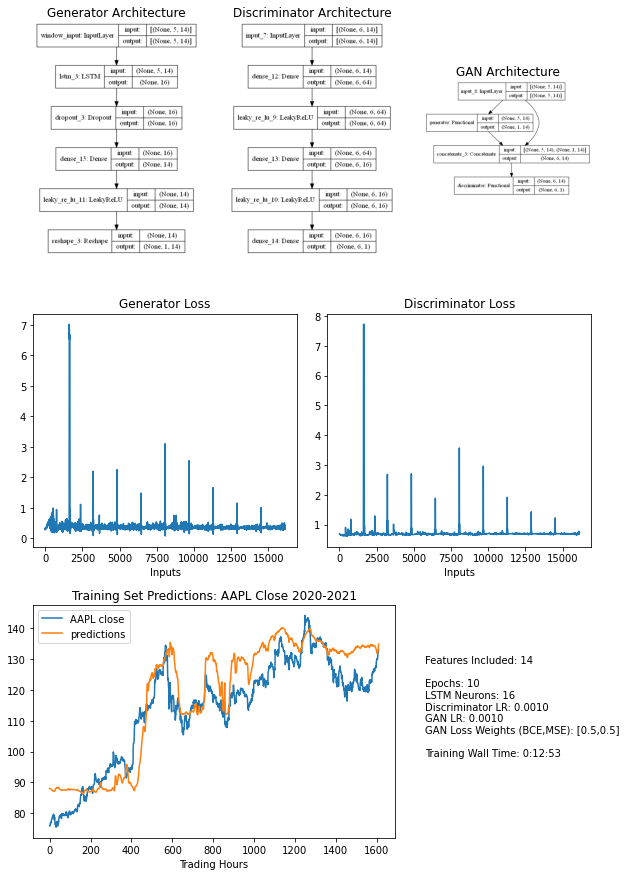

In [52]:
gs = gridspec.GridSpec(3,6)
gs.update(wspace=0.45,hspace=.25)
plt.figure(figsize=(10,15))
ax1 = plt.subplot(gs[0,:2],)
plt.title('Generator Architecture')
plt.imshow(img_gen)
plt.axis('off')
ax2 = plt.subplot(gs[0,2:4],)
plt.title('Discriminator Architecture')
plt.imshow(img_disc)
plt.axis('off')
ax7 = plt.subplot(gs[0,4:],)
plt.title('GAN Architecture')
plt.imshow(img_gan)
plt.axis('off')
ax3 = plt.subplot(gs[2,:4],)
plt.title('Training Set Predictions: AAPL Close 2020-2021')
plt.plot(real_close)
plt.plot(predictions_close)
plt.legend(['AAPL close','predictions'])
plt.xlabel('Trading Hours')
ax4 = plt.subplot(gs[2,4:],)
plt.axis('off')
plt.text(0.0,0.35,s=text)
ax5 = plt.subplot(gs[1,:3],)
plt.plot(generator_loss)
plt.xlabel('Inputs')
plt.title('Generator Loss')
ax6 = plt.subplot(gs[1,3:],)
plt.plot(discriminator_loss)
plt.xlabel('Inputs')
plt.title('Discriminator Loss')
fname = 'storage/combined_summaries/Summary_%s_.png' % (now)
plt.savefig(fname,facecolor='white',bbox_inches = 'tight')

In [41]:
#saving real_close
pickle_out = open('./storage/vis/realclose.pickle','wb')
pickle.dump(real_close,pickle_out)
pickle_out.close()

In [53]:
#saving for vis
#saving losses
pickle_out = open('./storage/vis/genloss_%d_epochs.pickle' % (epochs),'wb')
pickle_out1 = open('./storage/vis/discloss_%d_epochs.pickle' % (epochs),'wb')
pickle.dump(generator_loss,pickle_out)
pickle.dump(discriminator_loss,pickle_out1)
pickle_out.close()
pickle_out1.close()

#saving predictions_close
pickle_out = open('./storage/vis/predictionsclose_%d_epochs.pickle' % (epochs),'wb')
pickle.dump(predictions_close,pickle_out)
pickle_out.close()

---
### Model Summaries
---

In [ ]:
model_discriminator.summary()
model_generator.summary()

---
### Forecasting Ahead
---

In [ ]:
x_test = x_train[-1]
predicted,_ = generated_sample(x_test, model_generator)
predicted = predicted[0]
predicted = inverse_and_supply(predicted,scaler)
predicted = np.array([predicted])
print(predicted)

In [ ]:
left=2450
right=2550

plt.title('Training Set Predictions: AAPL Close 2011-2021')
plt.plot(np.concatenate((real_close,x_realpredicted)))
plt.plot(np.concatenate((predictions_close,predicted)))
plt.legend(['AAPL close','predictions'])
plt.xlabel('Trading Days')
plt.xlim(left,right)
plt.grid('on')
plt.xticks(np.arange(left,right,step=5))
plt.yticks(np.arange(0,160,step=20))
...